# Notas importantes
Dado que ya estaba bastante documentado el codigo y que se explicaba muy bien la parte del gradiente etc...<br>
Procedi a explicar los calculos matematicos que no estaban del todo explicadas<br>
Tecnicamente esta enfocado en demostrar las funciones utilizadas, y por que se usaron ciertas librerias de numpy

In [1]:
#### Libraries
# Standard library
import json #esta libreraria nos deja compartir informacion de forma ligera
import random #usado para generar numeros random
import sys #nos permite ver cosas del sistema

# Third-party libraries
import numpy as np #libreria enfocada al calculo vectorial
import math

## Funcion de costo cuadratico
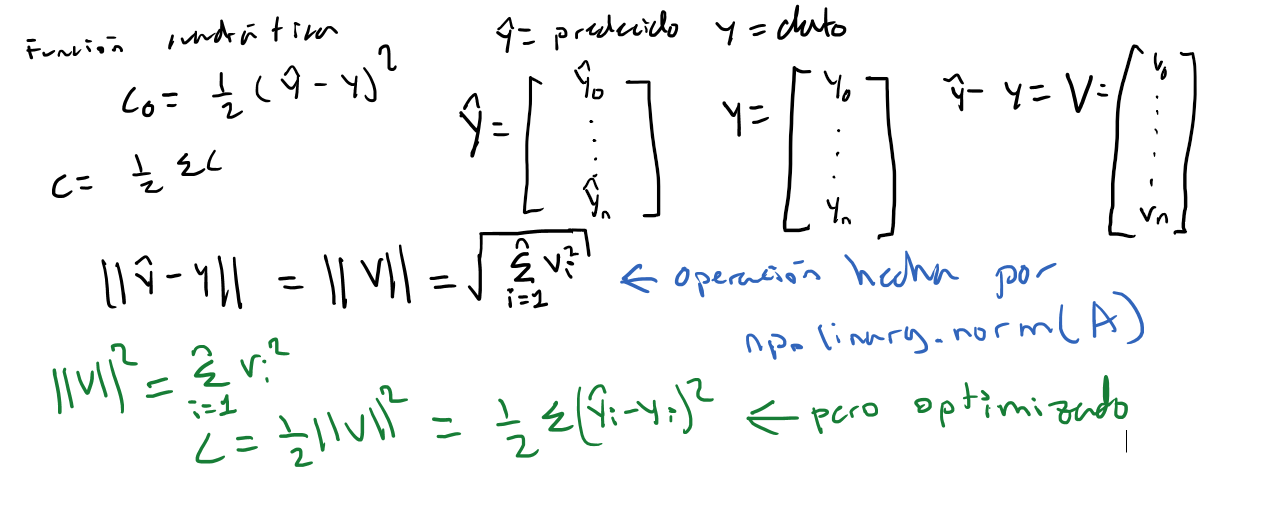

In [2]:
#Define la funcion de costo cuadratica
class QuadraticCost(object):
    
    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.
        """
        return 0.5*np.linalg.norm(a-y)**2 
    #Ejecuta la sumatoria al cuadrado de cada uno de las predicciones ejecutadas menos su respectiva respuesta
    #adicionalmente lo divide entre 2
    
    #Calcula la derivada de la funcion de costo, por la regla de la cadena
    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)

## Funcion np.linalg.norm(a)
Regresa la sumatoria de cada elemento del vector o matriz al cuadrado

In [3]:
#np.linalg.norm(a-y)
a = np.arange(9) - 4
print(a)
b=np.linalg.norm(a)
print(b)
c=0
for i in a:
    c+=i**2
print(c)
print(math.sqrt(c))

[-4 -3 -2 -1  0  1  2  3  4]
7.745966692414834
60
7.745966692414834


En este caso la funcion de costo se define de diferente forma, ya que se hace enfasis en la forma de la funcion sigmoid, la cual da un valor entre 0 y 1, lo cual hace que la diferencia que se tendria con el valor de prediccion sea menor a 1, y si dicha diferencia se eleva al cuadrado se minimizaria dado que la base es menor a 1.<br>
Para resolver esto se utiliza la siguiente funcion de costo

## CrossEntropyCost
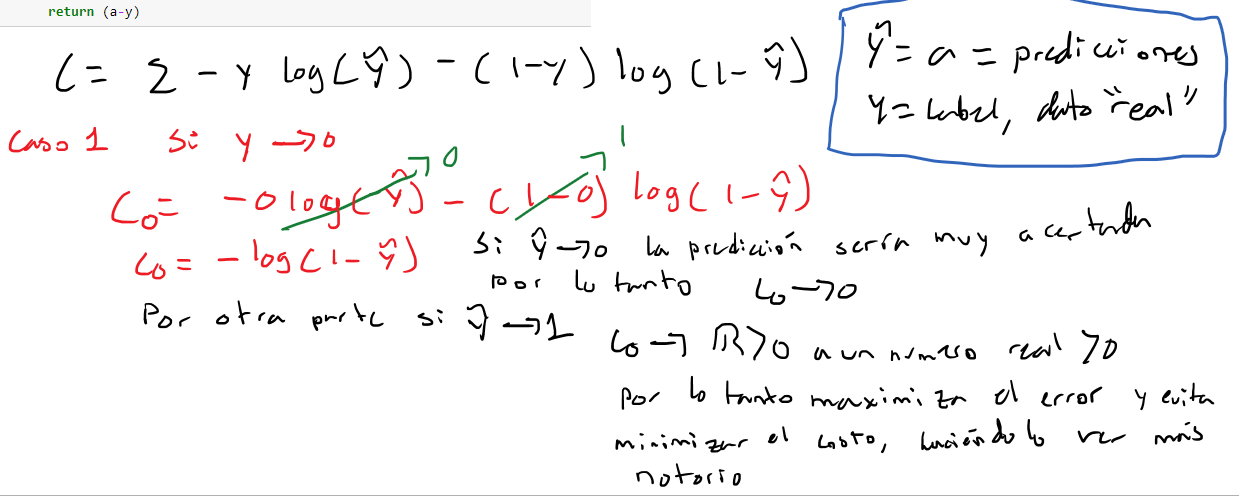
 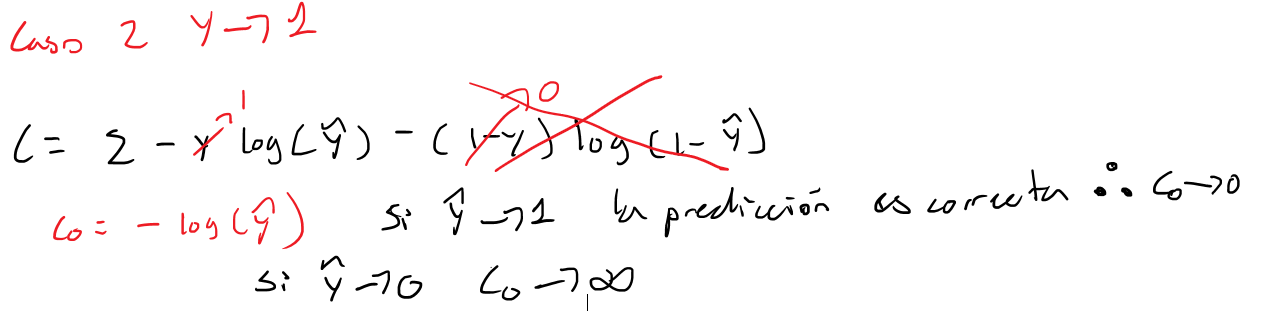
 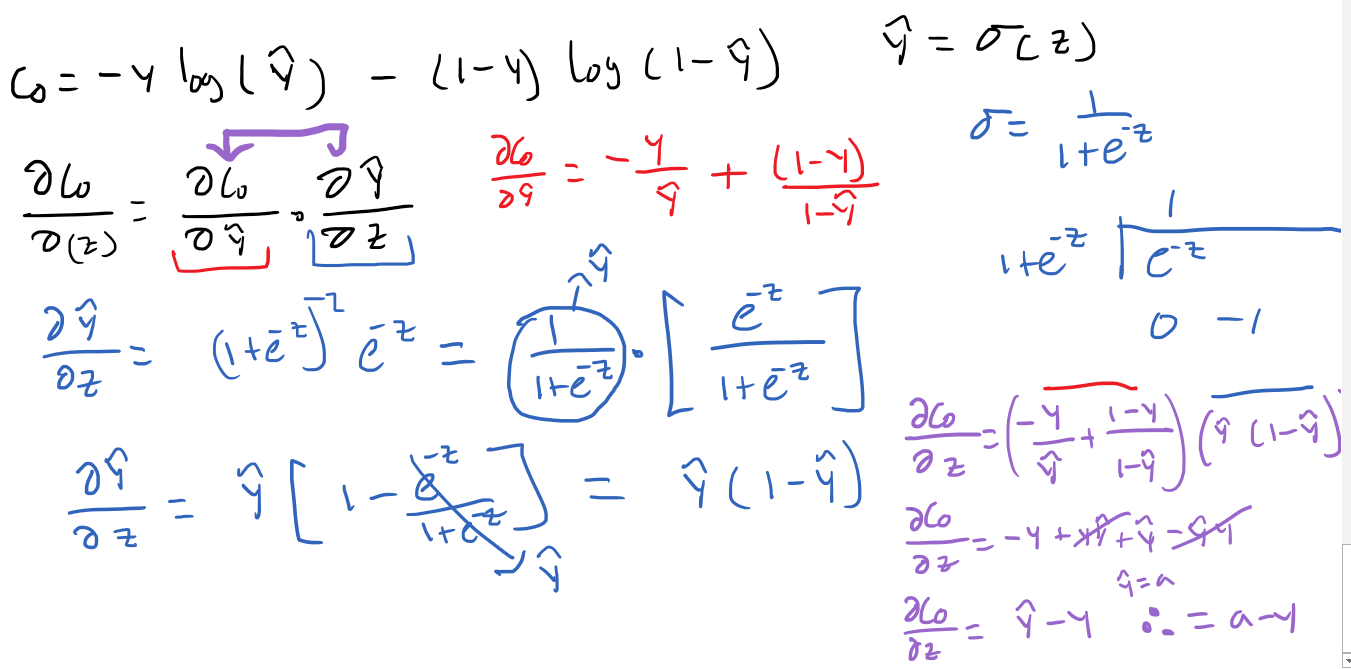

In [4]:
#Define la funcion de costo cross entropy
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).
        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.
        """
        return (a-y)

## Funcion np.nan_to_num(a)
Valida que el numero de argumento sea un numero, es muy util cuando en nuestro argumento tenemos un valor que tiende a un valor no valido

In [5]:
print(np.nan_to_num(np.log(-1)))
print(np.nan_to_num(np.log(0)*0))#Aqui deberia de explotar la funcion dado que tiene log(0)

0.0
0.0


C:\Users\yasuo\.conda\envs\computer_vision\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\yasuo\.conda\envs\computer_vision\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\yasuo\.conda\envs\computer_vision\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


## Feedforward 
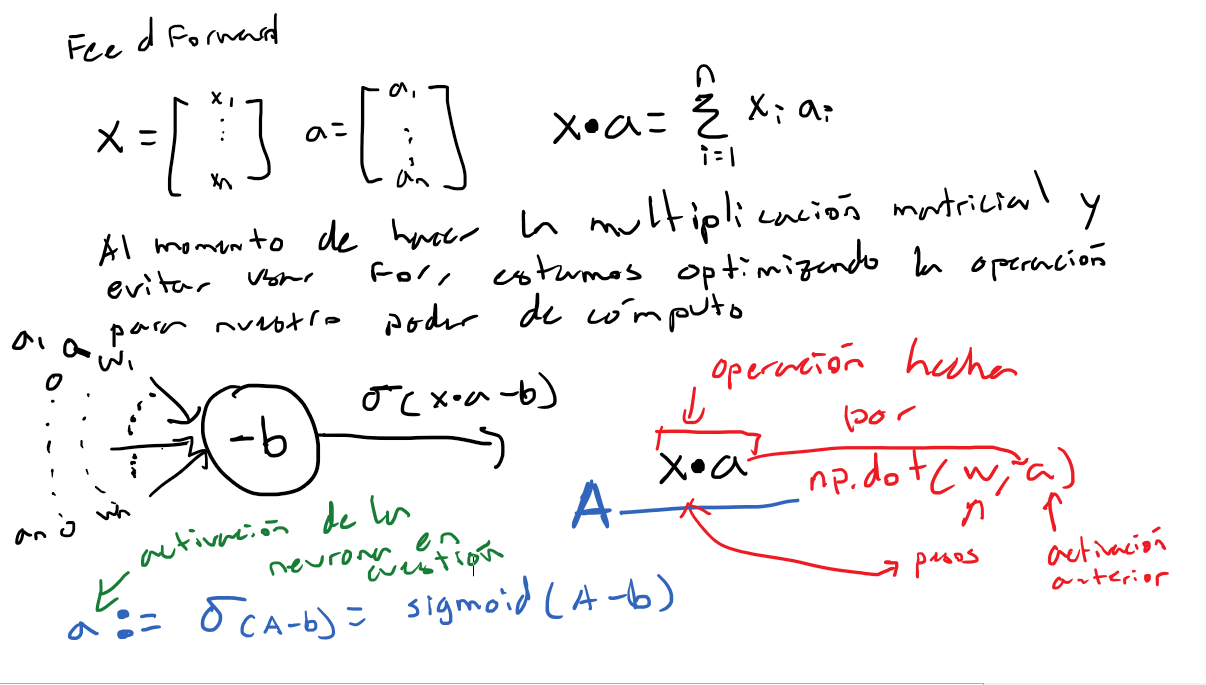

In [6]:
#### Main Network class
class Network(object):
    
    #Inicializa la red
    #Sizes se refiere a la cantidad de neuronas que tiene por capa,[primera capa,...,ultima capa]
    #CrossEntropyCost funcion de costo, utiliza el objeto hecho anteriormente
    def __init__(self, sizes, cost=CrossEntropyCost):
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost
    
    #Se inizializan los pesos de forma aleatoria mediante una funcion Gaussiana
    #esta funcion considera a la primera capa como una entrada de 
    def default_weight_initializer(self):
        
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
    
    #Otra forma de inizializar los pesos
    def large_weight_initializer(self):
        
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    #Ver imagen de arriba
    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    #SGD Descenso del gradiente estocastico
    #Training_data lista de tuplas donde (x=variables,y=labels)
    #epochs=la cantidad de veces que se repetira la red 
    #mini_batch_size=Tamano del lote de datos
    #eta es la taza de aprendizaje
    #evaluation_data nos permite ir revisando el proceso de entrenamiento
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            early_stopping_n = 0):

        # early stopping functionality:
        best_accuracy=1

        training_data = list(training_data)
        n = len(training_data)

        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)

        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        #ejecuta el algoritmo #epochs de veces
        for j in range(epochs):
            #revuelve los datos
            random.shuffle(training_data)
            #crea los mini lotes de datos
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            #Por cada lote en la cantidad de lotes
            for mini_batch in mini_batches:
                #calcula el gradiente
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            #muestra el progreso
            print("Epoch %s training complete" % j)
            
            #Si las banderas estan activas muestra el progreso que se lleva
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))

            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    #print("Early-stopping: Best so far {}".format(best_accuracy))
                else:
                    no_accuracy_change += 1

                if (no_accuracy_change == early_stopping_n):
                    #print("Early-stopping: No accuracy change in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy
    
    #Aplica descenso del gradiente para un subconjuntode datos mini_batch
    #eta es la taza de aprendizaje
    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
    
    #Ejecuta el descenso del gradiente para una muestra, regresa los valores
    #de cambio de los pesos y del bias
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    #Calcula la cantidad de veces en las que el algoritmo calculo de forma correcta la prediccion
    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.
        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.
        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy
    
    #Calcula el costo total de la iteracion
    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights) # '**' - to the power of.
        return cost
    
    #Guarda el modelo en un archivo json, este tipo de archivos nos permite compartir informacion de forma facil
    def save(self, filename):
        
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

In [7]:
#### Carga una red ya entrenada, tiene que estar en formato json
def load(filename):
    
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

In [8]:
#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.
    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

## Funcion sigmoid
Realiza la funcion sigmoid, el argumento z en el caso de las redes neuronales vendria siendo la sumatoria de todos los pesos de cada neurona por su nivel de activacion menos el bias de la neurona en cuestion
El resultado de la esta funcion es el nivel de activacion de la neurona

In [9]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

## Derivada de la funcion sigmoid
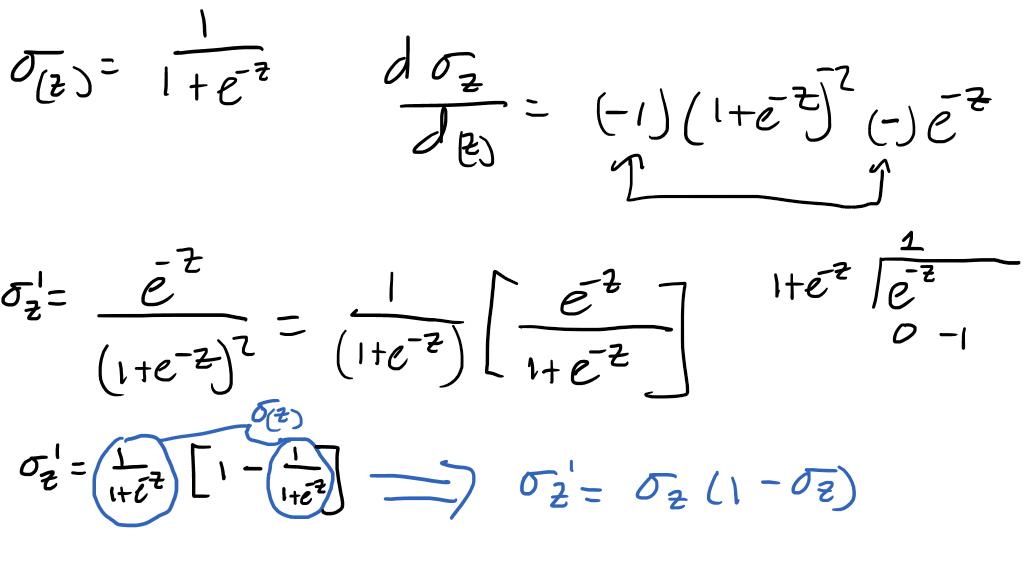

In [10]:
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))